In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import itertools as it
import time as time


In [5]:
data = pd.read_excel("owid-covid-data.xlsx")

In [6]:
# picking out our 10 countries that have relatively low missingness and that are adjacent 
country_list = ['Norway', 'Finland', 'Lithuania', 'Ireland', 'United Kingdom',
    'Italy', 'Belgium', 'Denmark', 'Switzerland', 'Poland']
selected_data = data[data['location'].isin(country_list)]
selected_data.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
28497,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28498,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28499,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,-151.3,-6.34,-6.34,-13.086293
28500,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN
28501,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,31.4,NaN,5.64,81.63,0.931,11655923,NaN,NaN,NaN,NaN


## Data Prep

### Removing irrelevant dates


Dates to remove specified in ARIMA file.

In [7]:
# Subset the dataset
data_clean = selected_data[(selected_data['date'] >= '2020-03-01') & (selected_data['date'] <= '2023-01-15')]

In [8]:
# check missingness
missing_values_count = data_clean['new_cases'].isnull().sum()
print(missing_values_count)

0


### Removing variables

#### Dropping more than 30% missingness

In [9]:

# create a table that shows the number of features with more than 30% missing values for each country
def missing_features_by_country(df):

    missingness = df.groupby('location').apply(lambda group: group.isna().mean() * 100)
    
    # Count the number of features with more than 30% missing values for each country
    features_missing_30 = (missingness > 30).sum(axis=1)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Country': features_missing_30.index,
        'Features with >30% Missingness': features_missing_30.values
    })
    
    return summary.sort_values(by='Features with >30% Missingness', ascending=True)

# Calculate and display the results
missing_features_summary = missing_features_by_country(data_clean)
print(missing_features_summary)

          Country  Features with >30% Missingness
4           Italy                               7
0         Belgium                               9
8     Switzerland                              13
1         Denmark                              16
3         Ireland                              16
2         Finland                              19
9  United Kingdom                              20
5       Lithuania                              22
6          Norway                              26
7          Poland                              27


In [10]:
#data missingness
missing_data = data_clean.isnull().sum()
threshold = 0.3 * len(data_clean)
missing_data = missing_data[missing_data < threshold]
missing_data

iso_code                              0
continent                             0
location                              0
date                                  0
total_cases                          25
new_cases                             0
new_cases_smoothed                    0
total_deaths                         81
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million              25
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million             81
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                   223
hosp_patients                      2499
hosp_patients_per_million          2499
total_tests                        3023
new_tests                          3146
total_tests_per_thousand           3023
new_tests_per_thousand             3146
new_tests_smoothed                 2365
new_tests_smoothed_per_thousand    2365


In [11]:
# drop features with >30% missingness
threshold = 0.7 * len(selected_data)

data_clean = data_clean.dropna(thresh=threshold, axis=1)
data_clean.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')

#### Removing constants

In [12]:

# Assuming 'df' is your DataFrame
df_grouped = data_clean.groupby('location')

threshold = 0.95

# For each location after grouping
constant_columns_by_location = df_grouped.apply(lambda group: group.columns[group.apply(lambda col: col.value_counts(normalize=True).max() >= threshold)])

constant_columns_df = constant_columns_by_location.reset_index(name='cons_variables')


print(constant_columns_df['cons_variables'].iloc[0])

Index(['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population'],
      dtype='object')


Constant Variables:

['iso_code', 'continent', 'location', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

Keeping location though!

In [13]:
variables_to_remove = ['iso_code', 'continent', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'population']

data_clean_subset = data_clean.drop(columns=variables_to_remove)
data_clean_subset.columns



Index(['location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed',
       'total_deaths', 'new_deaths', 'new_deaths_smoothed',
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million',
       'reproduction_rate', 'stringency_index'],
      dtype='object')

Still need to remove all the totals and smoothers: 'total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million'

In [14]:
remove = ['total_cases', 'total_deaths', 'new_cases_smoothed', 'new_deaths_smoothed', 
          'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
          'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million']

data_clean_subset = data_clean_subset.drop(columns=remove)
data_clean_subset.columns


Index(['location', 'date', 'new_cases', 'new_deaths', 'reproduction_rate',
       'stringency_index'],
      dtype='object')

In [15]:
data_clean_subset.head()

,location,date,new_cases,new_deaths,reproduction_rate,stringency_index
28555,Belgium,2020-03-01,0.0,0.0,NaN,11.11
28556,Belgium,2020-03-02,0.0,0.0,NaN,11.11
28557,Belgium,2020-03-03,18.0,0.0,NaN,11.11
28558,Belgium,2020-03-04,19.0,0.0,NaN,13.89
28559,Belgium,2020-03-05,34.0,0.0,NaN,13.89


#### Testing for Multicollinearity

In [16]:
## date as index
# Convert 'ds' to datetime if it's not already

data_clean_subset['date'] = pd.to_datetime(data_clean['date'])

data_clean_subset.set_index('date', inplace=True)

In [17]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


<Axes: >

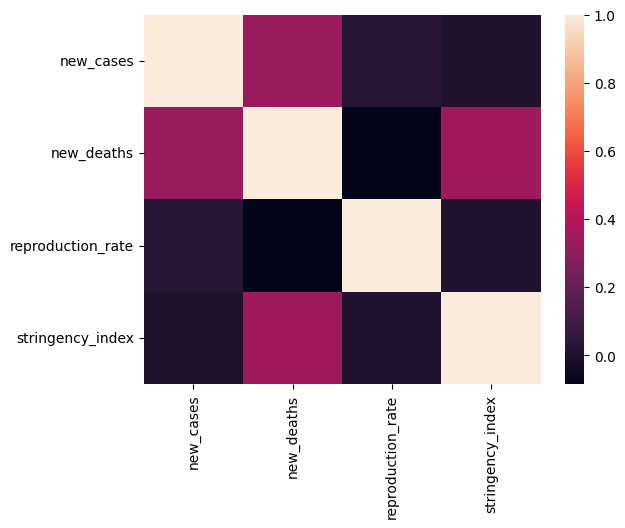

In [18]:
for_corr = data_clean_subset.copy().drop(columns=['location'])
correlation = for_corr.corr( method='pearson' )
sns.heatmap( correlation )

Pretty good on collinearity, can move forward with these variables.

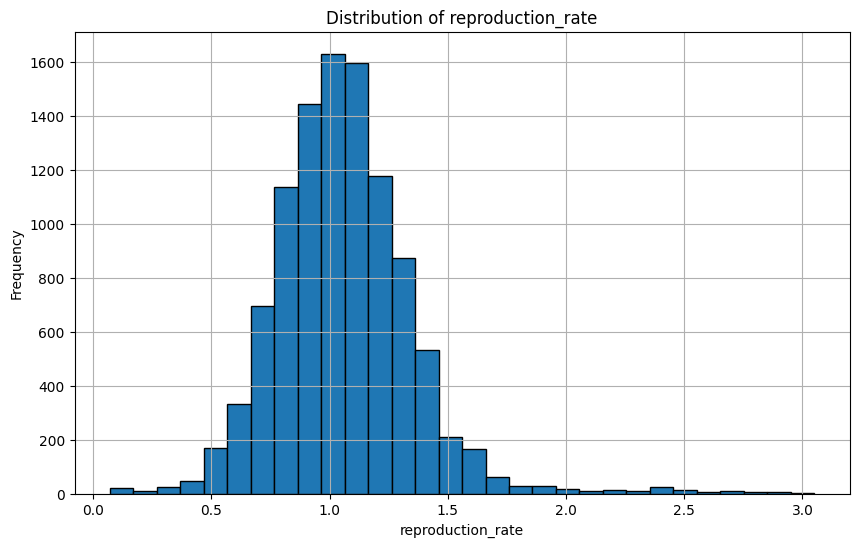

In [19]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'reproduction_rate'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

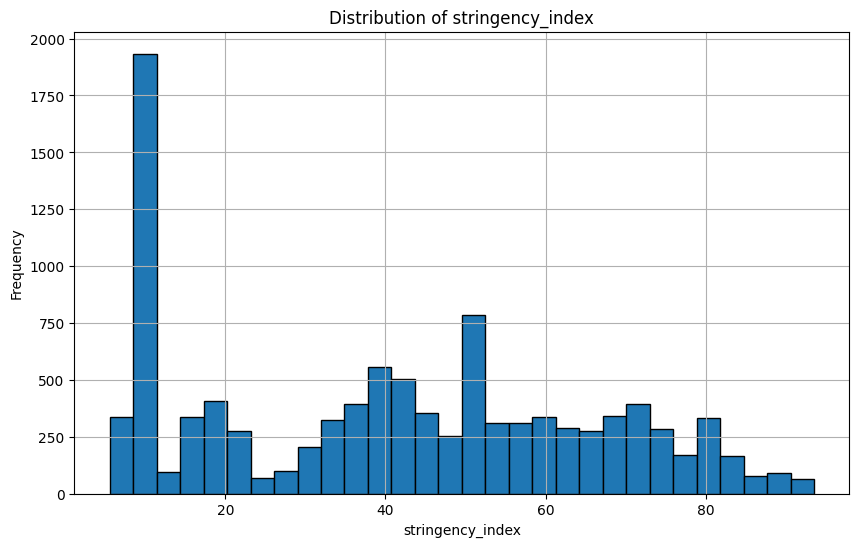

In [20]:
# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'stringency_index'

# Plotting the distribution
plt.figure(figsize=(10, 6))
data_clean_subset[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

#### Dealing with Outliers

In [21]:
data_clean_subset.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


In [22]:
na_counts = data_clean_subset.isna().sum()
print(na_counts)

location               0
new_cases              0
new_deaths             0
reproduction_rate    223
stringency_index     150
dtype: int64


In [23]:
from scipy import stats
import numpy as np

# Select only numeric columns
numeric_columns = data_clean_subset.select_dtypes(include='number')

# Calculate z-scores for each numeric column
z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for outlier detection
threshold = 4

# Replace outliers in numeric columns with NaN
data_clean_no_outliers = data_clean_subset.copy()
data_clean_no_outliers[numeric_columns.columns] = np.where(z_scores >= threshold, np.nan, data_clean_subset[numeric_columns.columns])

data_clean_no_outliers.head()



,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,NaN,11.11
2020-03-02,Belgium,0.0,0.0,NaN,11.11
2020-03-03,Belgium,18.0,0.0,NaN,11.11
2020-03-04,Belgium,19.0,0.0,NaN,13.89
2020-03-05,Belgium,34.0,0.0,NaN,13.89


In [24]:
na_counts = data_clean_no_outliers.isna().sum()
print(na_counts)

location               0
new_cases            129
new_deaths           146
reproduction_rate    223
stringency_index     150
dtype: int64


I want to use forward fill to impute new_cases and new_deaths, and impute the other two with the mean

In [25]:
# Forward fill new_cases and new_deaths
data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)

# Impute reproduction_rate and stringency_index with mean
grouped_means = data_clean_no_outliers.groupby('location')[['reproduction_rate', 'stringency_index']].mean()

# Fill missing values based on the mean of each location
data_clean_no_outliers = data_clean_no_outliers.join(grouped_means, on='location', rsuffix='_mean')
data_clean_no_outliers['reproduction_rate'].fillna(data_clean_no_outliers['reproduction_rate_mean'], inplace=True)
data_clean_no_outliers['stringency_index'].fillna(data_clean_no_outliers['stringency_index_mean'], inplace=True)

# Drop the temporary columns used for filling missing values
data_clean_no_outliers.drop(['reproduction_rate_mean', 'stringency_index_mean'], axis=1, inplace=True)

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/2874557633.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_cases'].fillna(method='ffill', inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/2874557633.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean_no_outliers['new_deaths'].fillna(method='ffill', inplace=True)


In [26]:
data_clean_no_outliers.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index
date,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11
2020-03-02,Belgium,0.0,0.0,1.12314,11.11
2020-03-03,Belgium,18.0,0.0,1.12314,11.11
2020-03-04,Belgium,19.0,0.0,1.12314,13.89
2020-03-05,Belgium,34.0,0.0,1.12314,13.89


## Feature Engineering

### Creating Lag Features

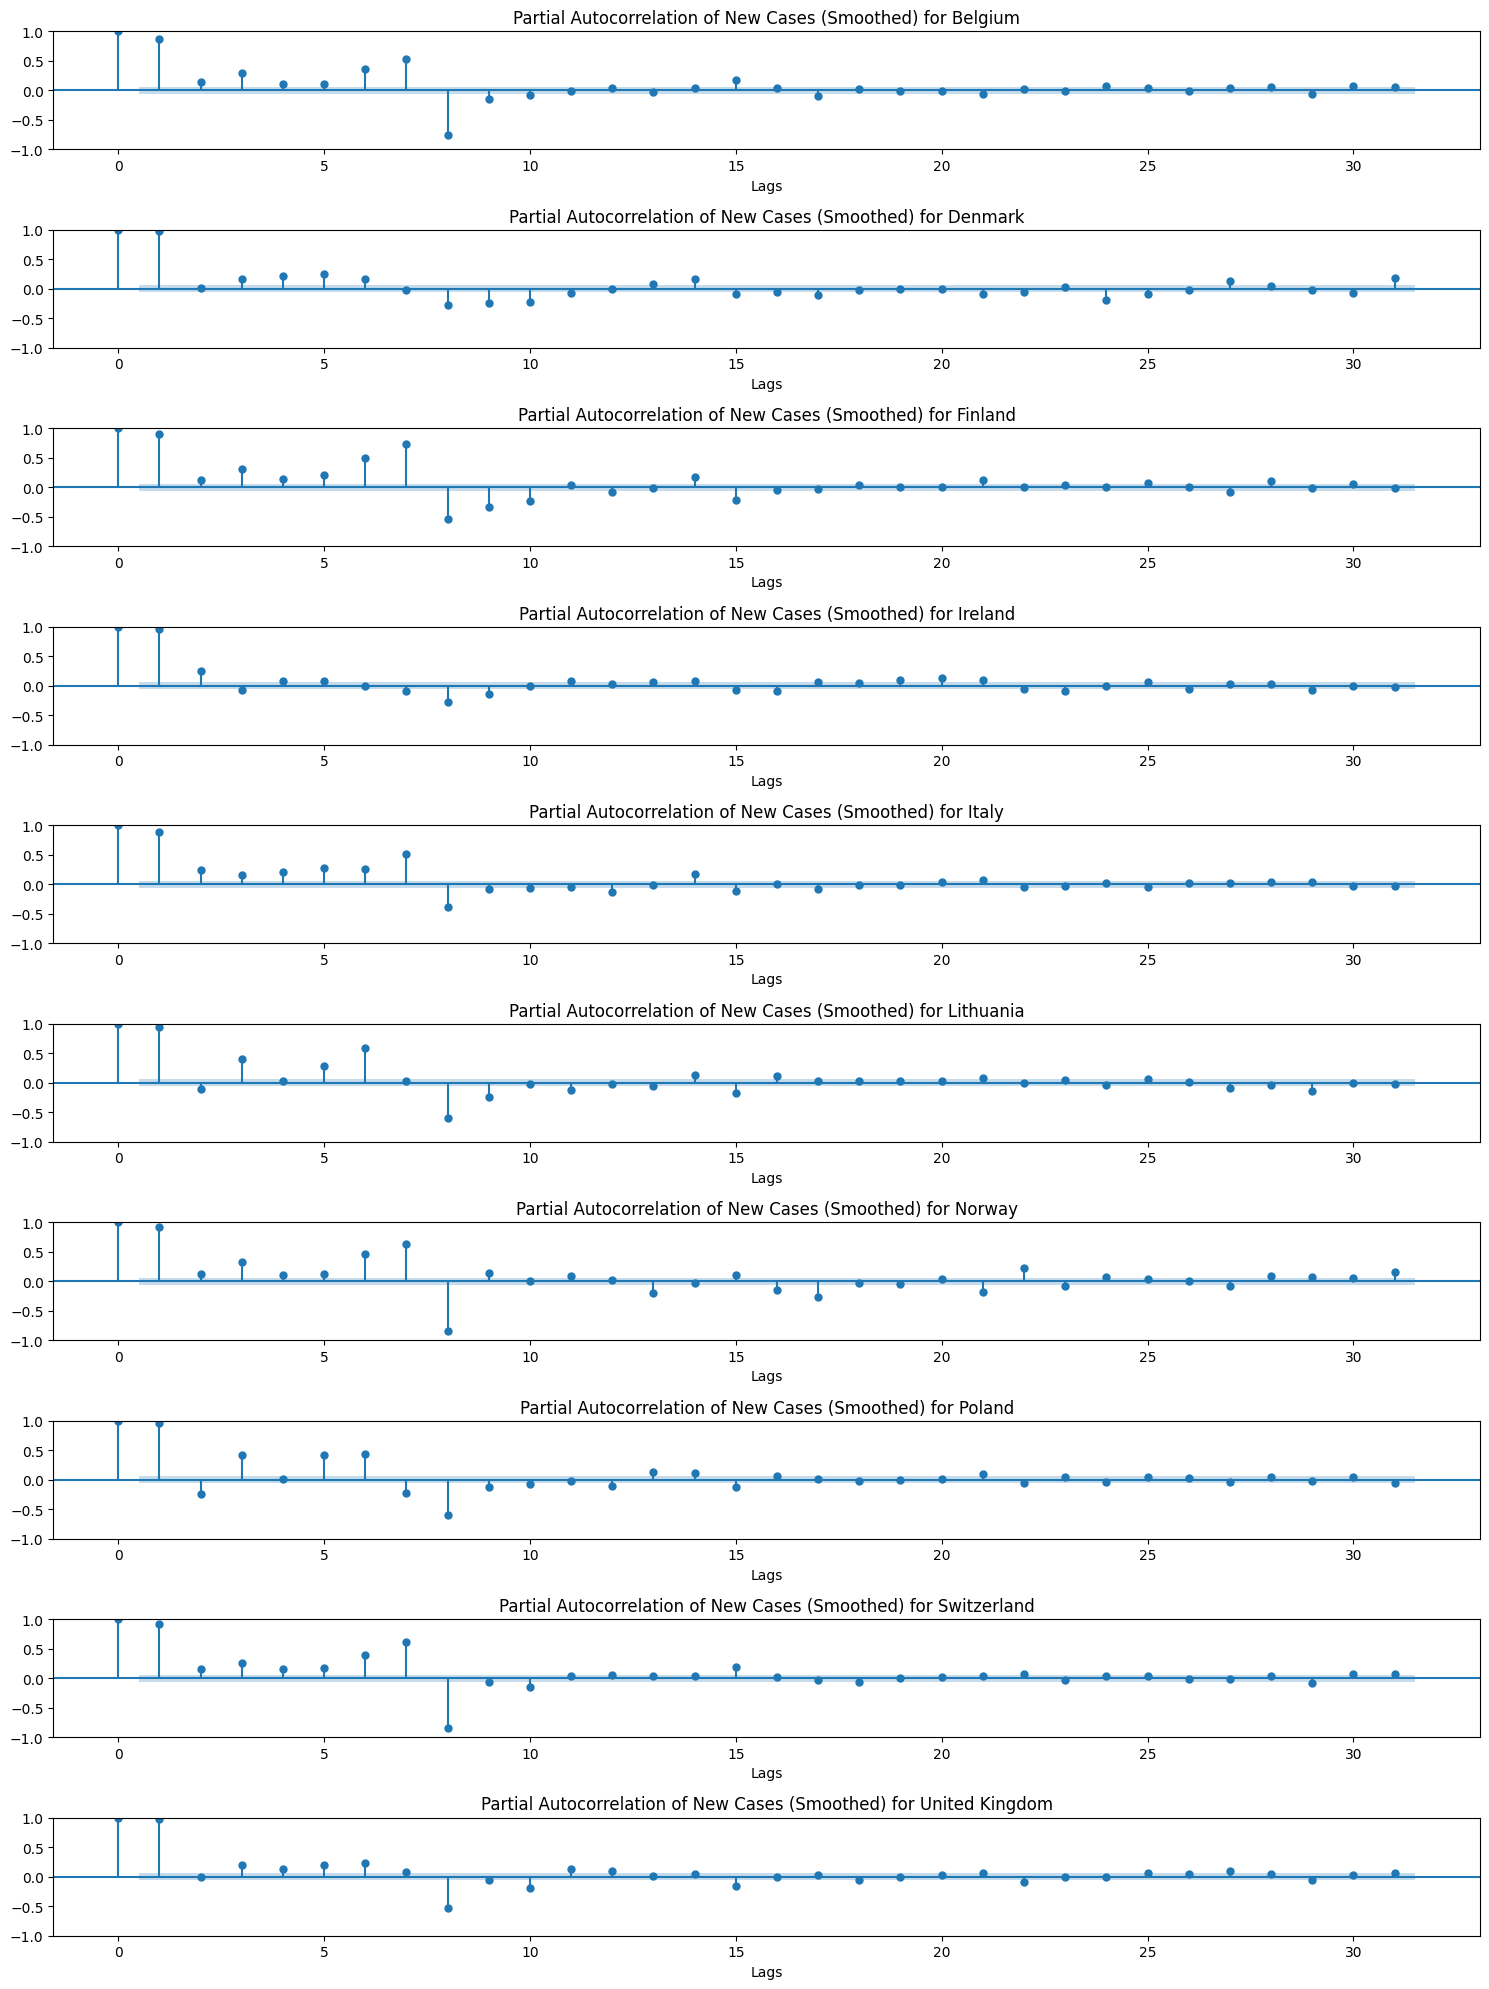

In [27]:
### Examining PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

countries = data_clean_no_outliers['location'].unique()

plt.figure(figsize=(15, 20))

for i, country in enumerate(countries, 1):
    plt.subplot(len(countries), 1, i)
    country_data = data_clean_no_outliers[data_clean_no_outliers['location'] == country]['new_cases']
    plot_pacf(country_data.dropna(), alpha=0.05, ax=plt.gca())
    plt.title(f'Partial Autocorrelation of New Cases (Smoothed) for {country}')
    plt.xlabel('Lags')

plt.tight_layout()
plt.show()

Spikes at lags 1 and 8, adding lags at 1 and 8.

In [28]:
data_clean_lag = data_clean_no_outliers.copy()

for lag in [1, 8]:
    data_clean_lag[f'new_cases_lag{lag}'] = data_clean_lag['new_cases'].shift(lag)

data_clean_lag.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8
date,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN


### Creating Rolling Mean Features

In [29]:
data_clean_roll_mean = data_clean_lag.copy()
# rolling window 7-day and 14-day for new_cases
for window in [7, 14]:
    data_clean_roll_mean[f'new_cases_roll_mean{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).mean()
    data_clean_roll_mean[f'new_cases_roll_std{window}'] = data_clean_roll_mean['new_cases'].rolling(window=window).std()

data_clean_roll_mean.head(10)

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14
date,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN
2020-03-06,Belgium,53.0,0.0,1.12314,13.89,34.0,NaN,NaN,NaN,NaN,NaN
2020-03-07,Belgium,81.0,0.0,2.43000,13.89,53.0,NaN,29.285714,29.460223,NaN,NaN
2020-03-08,Belgium,110.0,0.0,2.41000,13.89,81.0,NaN,45.000000,39.021362,NaN,NaN
2020-03-09,Belgium,27.0,1.0,2.41000,13.89,110.0,0.0,48.857143,34.954392,NaN,NaN


### Creating Time Features

#### Holidays and Seasons

In [30]:
import holidays

## changing date back to column
data_add_time = data_clean_roll_mean.reset_index()
data_add_time['date'] = pd.to_datetime(data_add_time['date'])

# Define the country for which you want to check holidays (e.g., 'US' for United States)
country_code = 'US'

# Get the list of holidays for the specified country
holiday_list = holidays.UnitedStates(years=data_add_time['date'].dt.year)

# Create a new column 'is_holiday' and set the values based on whether the date is a holiday or not
data_add_time['is_holiday'] = data_add_time['date'].isin(holiday_list).astype(int)
# Add a new column 'is_holiday' based on whether the date is a holiday
data_add_time.head(20)



,date,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday
0,2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0
2,2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0
3,2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0
4,2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0
5,2020-03-06,Belgium,53.0,0.0,1.12314,13.89,34.0,NaN,NaN,NaN,NaN,NaN,0
6,2020-03-07,Belgium,81.0,0.0,2.43000,13.89,53.0,NaN,29.285714,29.460223,NaN,NaN,0
7,2020-03-08,Belgium,110.0,0.0,2.41000,13.89,81.0,NaN,45.000000,39.021362,NaN,NaN,0
8,2020-03-09,Belgium,27.0,1.0,2.41000,13.89,110.0,0.0,48.857143,34.954392,NaN,NaN,0
9,2020-03-10,Belgium,64.0,0.0,2.40000,19.44,27.0,0.0,55.428571,32.418396,NaN,NaN,0


In [31]:
holiday_count = data_add_time['is_holiday'].eq(1).sum()
holiday_list

{datetime.date(2020, 1, 20): 'Martin Luther King Jr. Day', datetime.date(2020, 2, 17): "Washington's Birthday", datetime.date(2020, 10, 12): 'Columbus Day', datetime.date(2020, 1, 1): "New Year's Day", datetime.date(2020, 5, 25): 'Memorial Day', datetime.date(2020, 7, 4): 'Independence Day', datetime.date(2020, 7, 3): 'Independence Day (Observed)', datetime.date(2020, 9, 7): 'Labor Day', datetime.date(2020, 11, 11): 'Veterans Day', datetime.date(2020, 11, 26): 'Thanksgiving', datetime.date(2020, 12, 25): 'Christmas Day', datetime.date(2021, 1, 18): 'Martin Luther King Jr. Day', datetime.date(2021, 2, 15): "Washington's Birthday", datetime.date(2021, 10, 11): 'Columbus Day', datetime.date(2021, 1, 1): "New Year's Day", datetime.date(2021, 12, 31): "New Year's Day (Observed)", datetime.date(2021, 5, 31): 'Memorial Day', datetime.date(2021, 6, 19): 'Juneteenth National Independence Day', datetime.date(2021, 6, 18): 'Juneteenth National Independence Day (Observed)', datetime.date(2021, 7, 

In [32]:
## seasons
data_add_time['season'] = data_add_time['date'].apply(lambda x: 'Winter' if x.month == 12 or x.month == 1
                                                      or x.month == 2 else 'Spring' if x.month == 3 or 
                                                      x.month == 4 or x.month == 5 else 'Summer' if x.month == 6
                                                      or x.month == 7 or x.month == 8 else 'Autumn' if x.month == 9
                                                      or x.month == 10 or x.month == 11 else '')

data_add_time.head()

,date,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season
0,2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0,Spring
1,2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring
2,2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring
3,2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0,Spring
4,2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0,Spring


#### Day of Week and Weekends

In [33]:
data_add_time.set_index('date', inplace = True)
data_add_time['day_of_week'] = data_add_time.index.dayofweek

data_add_time['weekend'] = np.where(data_add_time['day_of_week'].isin([5, 6]), 1, 0)
data_add_time['month'] = data_add_time.index.month
data_add_time['year'] = data_add_time.index.year
data_add_time['quarter'] = data_add_time.index.quarter
data_add_time['dayofyear'] = data_add_time.index.dayofyear
data_add_time['dayofmonth'] = data_add_time.index.day

In [34]:
data_add_time.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,NaN,NaN,NaN,NaN,NaN,NaN,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,NaN,NaN,NaN,NaN,NaN,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,NaN,NaN,NaN,NaN,NaN,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,NaN,NaN,NaN,NaN,NaN,0,Spring,3,0,3,2020,1,65,5


In [35]:
cleaned_df = data_add_time.copy()
cleaned_df.fillna(0, inplace = True)
cleaned_df.head()


,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,0.0,0.0,0.0,0.0,0.0,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,0.0,0.0,0.0,0.0,0.0,0,Spring,3,0,3,2020,1,65,5


## Normalization

In [36]:
cleaned_df.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,0.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,0.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,18.0,0.0,1.12314,11.11,0.0,0.0,0.0,0.0,0.0,0.0,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,19.0,0.0,1.12314,13.89,18.0,0.0,0.0,0.0,0.0,0.0,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,34.0,0.0,1.12314,13.89,19.0,0.0,0.0,0.0,0.0,0.0,0,Spring,3,0,3,2020,1,65,5


In [73]:
features_to_normalize = ['new_cases', 'new_deaths', 'reproduction_rate', 'stringency_index',
                         'new_cases_lag1', 'new_cases_lag8', 'new_cases_roll_mean7', 'new_cases_roll_std7',
                         'new_cases_roll_mean14', 'new_cases_roll_std14']

def normalize_by_location(df):
    normalization_values = {}
    for location, group in df.groupby('location'):
        normalization_values[location] = {}
        for col in features_to_normalize:
            mean = group[col].mean()
            std = group[col].std()
            df.loc[group.index, col] = (group[col] - mean) / std
            normalization_values[location][col] = {'mean': mean, 'std': std}
    return df, normalization_values

normalized_df, normalization_values = normalize_by_location(cleaned_df)
normalized_df.head()



,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,-0.946762,-0.965679,-3.921168e-16,-1.262992,-0.942306,-0.936442,-0.955060,-0.888205,-0.959142,-0.953350,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,-0.947143,-0.965679,-3.921168e-16,-1.262992,-0.946592,-0.938631,-0.957276,-0.890109,-0.960458,-0.950921,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,-0.946381,-0.965679,4.747531e+00,-1.262992,-0.946973,-0.930113,-0.958813,-0.892276,-0.962049,-0.954401,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,-0.945381,-0.960052,4.783134e+00,-1.262992,-0.946211,-0.934015,-0.959934,-0.896012,-0.963390,-0.958744,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,-0.944571,-0.965679,4.818737e+00,-1.262992,-0.945211,-0.935871,-0.960730,-0.900347,-0.964329,-0.961175,0,Spring,3,0,3,2020,1,65,5


{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0, 'subsample': 1.0}

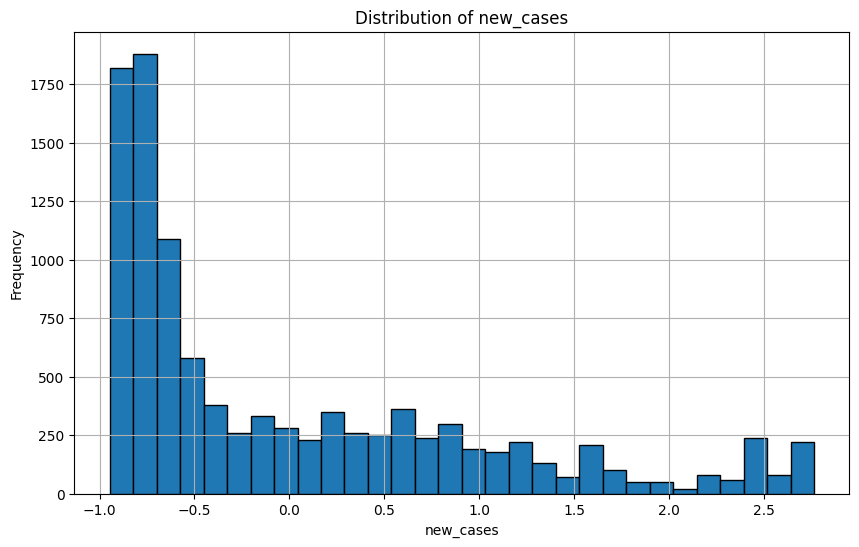

In [38]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data_clean_no_outliers' and the column is 'your_column_name'
column_to_plot = 'new_cases'

# Plotting the distribution
plt.figure(figsize=(10, 6))
normalized_df[column_to_plot].hist(bins=30, edgecolor='black')
plt.title(f'Distribution of {column_to_plot}')
plt.xlabel(column_to_plot)
plt.ylabel('Frequency')
plt.show()

#### Label Encode first

In [39]:
cleaned_df.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,season,day_of_week,weekend,month,year,quarter,dayofyear,dayofmonth
date,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,-0.946762,-0.965679,0.000000,-1.262992,-0.942306,-0.936442,-0.955060,-0.888205,-0.959142,-0.953350,0,Spring,6,1,3,2020,1,61,1
2020-03-02,Belgium,-0.947143,-0.965679,0.000000,-1.262992,-0.946592,-0.938631,-0.957276,-0.890109,-0.960458,-0.950921,0,Spring,0,0,3,2020,1,62,2
2020-03-03,Belgium,-0.946381,-0.965679,4.747531,-1.262992,-0.946973,-0.930113,-0.958813,-0.892276,-0.962049,-0.954401,0,Spring,1,0,3,2020,1,63,3
2020-03-04,Belgium,-0.945381,-0.960052,4.783134,-1.262992,-0.946211,-0.934015,-0.959934,-0.896012,-0.963390,-0.958744,0,Spring,2,0,3,2020,1,64,4
2020-03-05,Belgium,-0.944571,-0.965679,4.818737,-1.262992,-0.945211,-0.935871,-0.960730,-0.900347,-0.964329,-0.961175,0,Spring,3,0,3,2020,1,65,5


In [40]:
from sklearn.preprocessing import LabelEncoder
cleaned_df_encode = cleaned_df.copy()
# label for ordinal
le = LabelEncoder()
cleaned_df_encode['day_of_week_encoded'] = le.fit_transform(cleaned_df_encode['day_of_week'])
cleaned_df_encode['month_encoded'] = le.fit_transform(cleaned_df_encode['month'])
cleaned_df_encode['year_encoded'] = le.fit_transform(cleaned_df_encode['year'])
cleaned_df_encode['quarter_encoded'] = le.fit_transform(cleaned_df_encode['quarter'])
cleaned_df_encode['dayofyear_encoded'] = le.fit_transform(cleaned_df_encode['dayofyear'])
cleaned_df_encode['dayofmonth_encoded'] = le.fit_transform(cleaned_df_encode['dayofmonth'])



In [41]:
cleaned_df_encode.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,...,year,quarter,dayofyear,dayofmonth,day_of_week_encoded,month_encoded,year_encoded,quarter_encoded,dayofyear_encoded,dayofmonth_encoded
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,-0.946762,-0.965679,0.000000,-1.262992,-0.942306,-0.936442,-0.955060,-0.888205,-0.959142,...,2020,1,61,1,6,2,0,0,60,0
2020-03-02,Belgium,-0.947143,-0.965679,0.000000,-1.262992,-0.946592,-0.938631,-0.957276,-0.890109,-0.960458,...,2020,1,62,2,0,2,0,0,61,1
2020-03-03,Belgium,-0.946381,-0.965679,4.747531,-1.262992,-0.946973,-0.930113,-0.958813,-0.892276,-0.962049,...,2020,1,63,3,1,2,0,0,62,2
2020-03-04,Belgium,-0.945381,-0.960052,4.783134,-1.262992,-0.946211,-0.934015,-0.959934,-0.896012,-0.963390,...,2020,1,64,4,2,2,0,0,63,3
2020-03-05,Belgium,-0.944571,-0.965679,4.818737,-1.262992,-0.945211,-0.935871,-0.960730,-0.900347,-0.964329,...,2020,1,65,5,3,2,0,0,64,4


## Tuning Hyper Params

learning_rate 
batch_size 
epochs 
sequence_length 

In [46]:
data_prepped = cleaned_df_encode.copy()
drop = ['season', 'day_of_week', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth']

data_prepped = data_prepped.drop(columns = drop)
data_prepped.head()

,location,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,weekend,day_of_week_encoded,month_encoded,year_encoded,quarter_encoded,dayofyear_encoded,dayofmonth_encoded
date,,,,,,,,,,,,,,,,,,,
2020-03-01,Belgium,-0.946762,-0.965679,0.000000,-1.262992,-0.942306,-0.936442,-0.955060,-0.888205,-0.959142,-0.953350,0,1,6,2,0,0,60,0
2020-03-02,Belgium,-0.947143,-0.965679,0.000000,-1.262992,-0.946592,-0.938631,-0.957276,-0.890109,-0.960458,-0.950921,0,0,0,2,0,0,61,1
2020-03-03,Belgium,-0.946381,-0.965679,4.747531,-1.262992,-0.946973,-0.930113,-0.958813,-0.892276,-0.962049,-0.954401,0,0,1,2,0,0,62,2
2020-03-04,Belgium,-0.945381,-0.960052,4.783134,-1.262992,-0.946211,-0.934015,-0.959934,-0.896012,-0.963390,-0.958744,0,0,2,2,0,0,63,3
2020-03-05,Belgium,-0.944571,-0.965679,4.818737,-1.262992,-0.945211,-0.935871,-0.960730,-0.900347,-0.964329,-0.961175,0,0,3,2,0,0,64,4


### Subsetting Belgium for the Grid Search

In [48]:
data_belgium = data_prepped[data_prepped['location']=='Belgium']
data_belgium.drop('location', axis=1, inplace=True)
# make index from 0 to length of data
data_belgium.reset_index(drop=True, inplace=True)
data_belgium.head()

/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/4015986079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_belgium.drop('location', axis=1, inplace=True)


,new_cases,new_deaths,reproduction_rate,stringency_index,new_cases_lag1,new_cases_lag8,new_cases_roll_mean7,new_cases_roll_std7,new_cases_roll_mean14,new_cases_roll_std14,is_holiday,weekend,day_of_week_encoded,month_encoded,year_encoded,quarter_encoded,dayofyear_encoded,dayofmonth_encoded
0,-0.946762,-0.965679,0.000000,-1.262992,-0.942306,-0.936442,-0.955060,-0.888205,-0.959142,-0.953350,0,1,6,2,0,0,60,0
1,-0.947143,-0.965679,0.000000,-1.262992,-0.946592,-0.938631,-0.957276,-0.890109,-0.960458,-0.950921,0,0,0,2,0,0,61,1
2,-0.946381,-0.965679,4.747531,-1.262992,-0.946973,-0.930113,-0.958813,-0.892276,-0.962049,-0.954401,0,0,1,2,0,0,62,2
3,-0.945381,-0.960052,4.783134,-1.262992,-0.946211,-0.934015,-0.959934,-0.896012,-0.963390,-0.958744,0,0,2,2,0,0,63,3
4,-0.944571,-0.965679,4.818737,-1.262992,-0.945211,-0.935871,-0.960730,-0.900347,-0.964329,-0.961175,0,0,3,2,0,0,64,4


In [50]:
# manupulate data for LSTM
def make_series(data):
    series = []
    for i in range(len(data)-14):
        sub_seq = data[i:i+14]
        series.append((sub_seq.index[-1], sub_seq['new_cases'].values[-1], sub_seq.drop('new_cases', axis=1).values))
    return series

series_belgium = make_series(data_belgium)
print(series_belgium[0][0],series_belgium[0][1].shape,series_belgium[0][2].shape)

13 () (14, 17)


In [51]:
train_belgium = series_belgium[:-14]
test_belgium = series_belgium[-14:]

In [53]:
# set up grid search for hyperparameters, including learning rate, batch size, and LSTM units
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
n_epochs = 500
sequence_length = 14
n_units = [32, 64]
early_stopping_patience = [10, 20]

def build_model(x, y, learning_rate=0.001, batch_size=32, n_epochs=500, sequence_length=14, n_units=32, early_stopping_patience=10):
    inputs = keras.layers.Input(shape=(sequence_length,17))
    lstm_out = keras.layers.LSTM(n_units)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss="mae")
    history = model.fit(x, y, batch_size=batch_size, epochs=n_epochs, shuffle=True, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=early_stopping_patience, verbose=1)])
    return history, model

x=np.array([x[2].reshape(14,17) for x in train_belgium])
y=np.array([x[1] for x in train_belgium])
print(x.shape)
print(y.shape)

# grid search
histories = []
models = []
for lr in learning_rates:
    for bs in batch_sizes:
        for n_unit in n_units:
            for patience in early_stopping_patience:
                print('learning rate: {}, batch size: {}, LSTM units: {}, early stopping patience: {}'.format(lr, bs, n_unit, patience))
                history, model = build_model(x, y, learning_rate=lr, batch_size=bs, n_epochs=n_epochs, sequence_length=sequence_length, n_units=n_unit, early_stopping_patience=patience)
                histories.append(history)
                models.append(model)

(1023, 14, 17)
(1023,)
learning rate: 0.01, batch size: 32, LSTM units: 32, early stopping patience: 10


2023-12-06 15:47:13.596356: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-06 15:47:13.596443: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 15:47:13.596458: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 15:47:13.596717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 15:47:13.597144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/500


2023-12-06 15:47:14.386836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 2s 22ms/step - loss: 0.6457 - val_loss: 0.3287
Epoch 2/500
26/26 [==============================] - 0s 8ms/step - loss: 0.3087 - val_loss: 0.3804
Epoch 3/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2226 - val_loss: 0.2168
Epoch 4/500
26/26 [==============================] - 0s 9ms/step - loss: 0.2070 - val_loss: 0.1403
Epoch 5/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2033 - val_loss: 0.1388
Epoch 6/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1780 - val_loss: 0.1577
Epoch 7/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1999 - val_loss: 0.3019
Epoch 8/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1841 - val_loss: 0.2861
Epoch 9/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1665 - val_loss: 0.4198
Epoch 10/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1632 - val_loss: 0.1165
Epoch 11/500
26/26 [

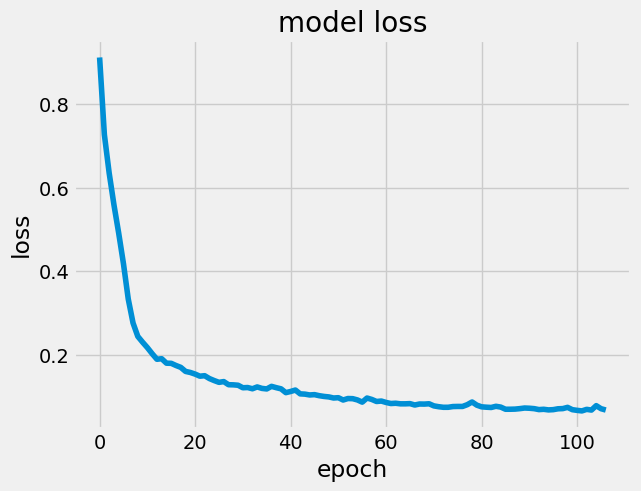

In [55]:
# find the best model
min_val_loss = 1000000
best_model = None
for model in models:
    if min(model.history.history['val_loss']) < min_val_loss:
        min_val_loss = min(model.history.history['val_loss'])
        best_model = model
        
# print loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [57]:
train_pred=pd.DataFrame(best_model.predict(x), columns=['yhat'], index=[x[0] for x in train_belgium ])
train_pred.head()

32/32 [==============================] - 0s 3ms/step


,yhat
13,-0.834218
14,-0.825686
15,-0.852708
16,-0.841586
17,-0.829665


1/1 [==============================] - 0s 45ms/step


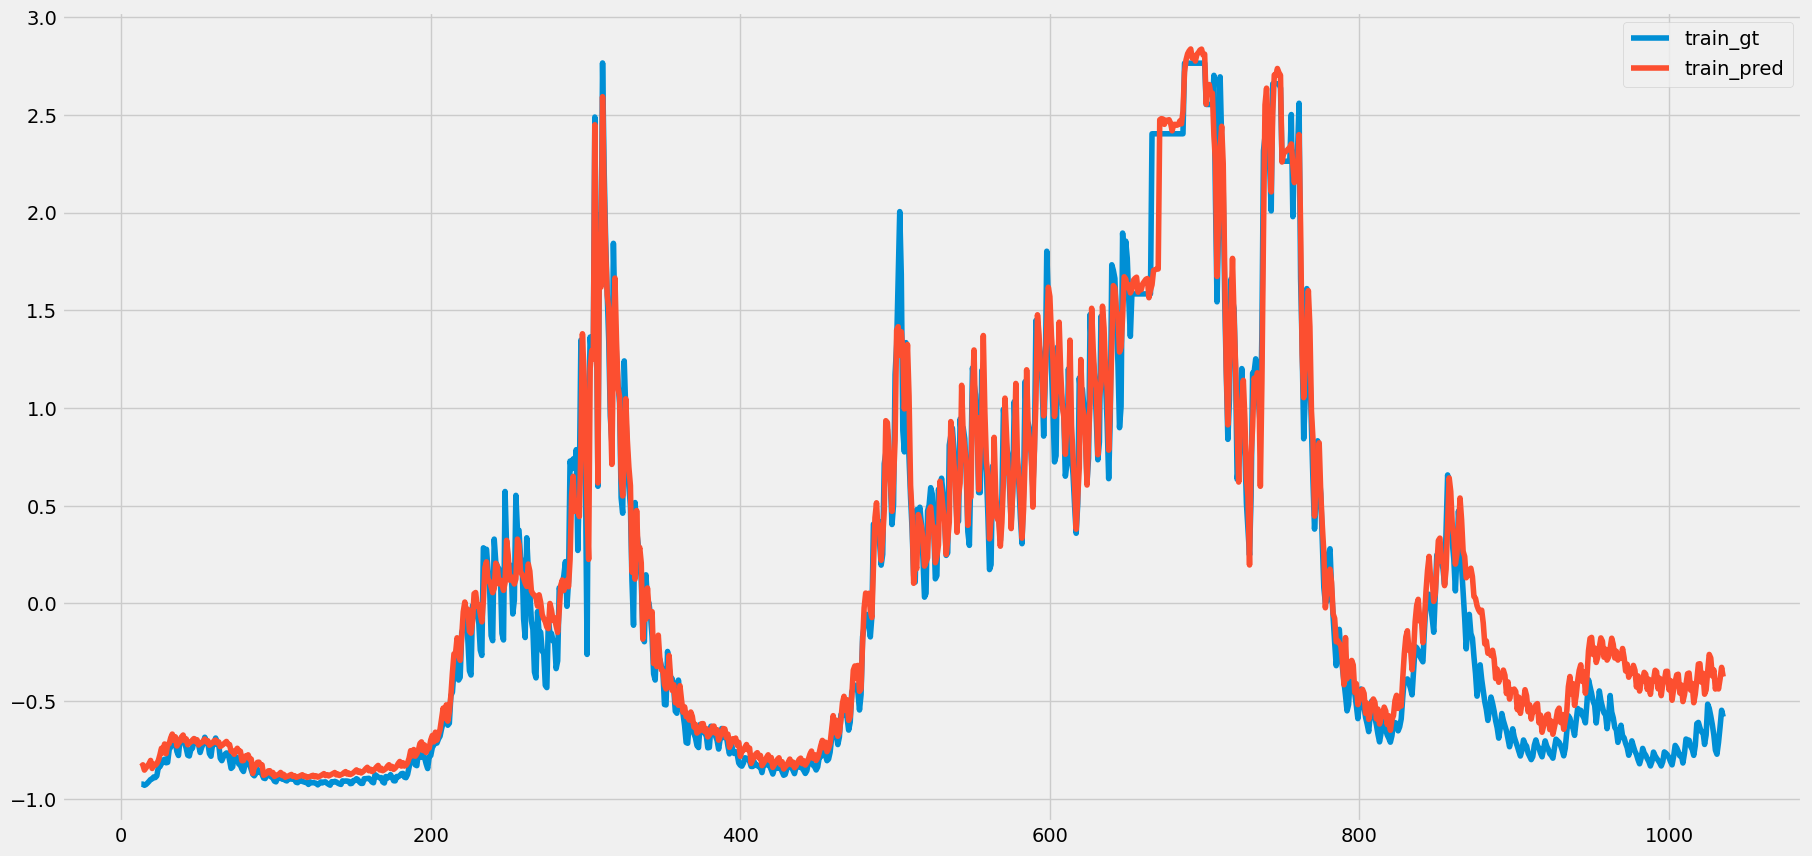

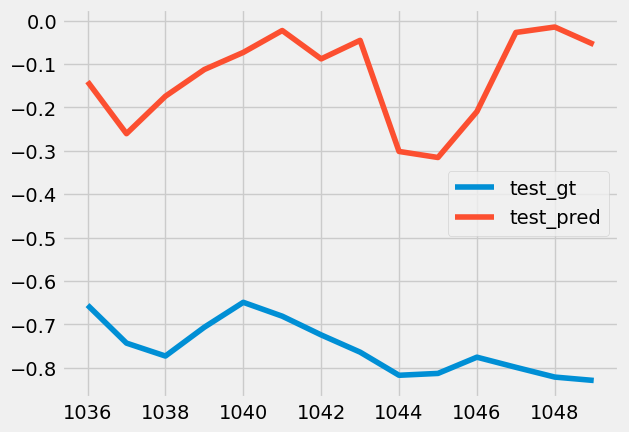

In [59]:

train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train_belgium ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

test_gt=pd.DataFrame([x[1] for x in test_belgium], columns=['y'], index=[x[0] for x in test_belgium ])
test_pred=best_model.predict(np.array([x[2].reshape(14,17) for x in test_belgium]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test_belgium ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [64]:
best_val_loss = float('inf')
best_params = None
best_model_index = None

# Iterate through each model's history and find the one with the lowest validation loss
for i, history in enumerate(histories):
    # Get the last recorded validation loss for the current model
    current_val_loss = history.history['val_loss'][-1]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_model_index = i

# Calculate the indices in the hyperparameter lists
lr_index = best_model_index % len(learning_rates)
bs_index = (best_model_index // len(learning_rates)) % len(batch_sizes)
n_unit_index = (best_model_index // (len(learning_rates) * len(batch_sizes))) % len(n_units)
patience_index = (best_model_index // (len(learning_rates) * len(batch_sizes) * len(n_units))) % len(early_stopping_patience)

# Retrieve the best hyperparameters
best_params = {
    'learning_rate': learning_rates[lr_index],
    'batch_size': batch_sizes[bs_index],
    'n_units': n_units[n_unit_index],
    'early_stopping_patience': early_stopping_patience[patience_index]
}

print('Best Hyperparameters:')
print('Learning Rate:', best_params['learning_rate'])
print('Batch Size:', best_params['batch_size'])
print('LSTM Units:', best_params['n_units'])
print('Early Stopping Patience:', best_params['early_stopping_patience'])


Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 32
LSTM Units: 32
Early Stopping Patience: 20


#### Optimal Parameters
Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 32
LSTM Units: 32
Early Stopping Patience: 20

In [95]:
from numpy import sqrt
train_rmse = {}
test_rmse = {}
train_plot_data = {}
test_plot_data = {}

country_list = data_prepped['location'].unique()
country_data = {}
for country in country_list:
    country_data[country] = data_prepped[data_prepped['location'] == country]
    country_data[country].drop('location', axis=1, inplace=True)
    country_data[country].reset_index(drop=True, inplace=True)

country_series = {}
for country in country_list:
    country_series[country] = make_series(country_data[country])

country_train = {}
country_test = {}
for country in country_list:
    country_train[country] = country_series[country][:-14]
    country_test[country] = country_series[country][-14:]

# Train model and make predictions
country_model = {}
for country in country_list:
    x_train = np.array([x[2].reshape(14,17) for x in country_train[country]])
    y_train = np.array([x[1] for x in country_train[country]])
    history, model = build_model(x_train, y_train, learning_rate=0.001, batch_size=32, n_epochs=500, sequence_length=14, n_units=32, early_stopping_patience=20)
    country_model[country] = model

    # train
    train_pred = model.predict(x_train)
    train_plot_data[country] = (y_train, train_pred)
    train_rmse[country] = sqrt(mean_squared_error(y_train, train_pred))

    # test
    x_test = np.array([x[2].reshape(14,17) for x in country_test[country]])
    test_pred = model.predict(x_test)
    y_test = np.array([x[1] for x in country_test[country]])
    test_plot_data[country] = (y_test, test_pred)
    test_rmse[country] = sqrt(mean_squared_error(y_test, test_pred))


/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/4194349190.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data[country].drop('location', axis=1, inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/4194349190.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data[country].drop('location', axis=1, inplace=True)
/var/folders/rt/z4vyc0q16r1f4wgfk65s0psm0000gn/T/ipykernel_13275/4194349190.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Epoch 1/500
26/26 [==============================] - 2s 32ms/step - loss: 0.8151 - val_loss: 0.5399
Epoch 2/500
26/26 [==============================] - 0s 13ms/step - loss: 0.5719 - val_loss: 0.5803
Epoch 3/500
26/26 [==============================] - 0s 10ms/step - loss: 0.4098 - val_loss: 0.7539
Epoch 4/500
26/26 [==============================] - 0s 9ms/step - loss: 0.3184 - val_loss: 0.7863
Epoch 5/500
26/26 [==============================] - 0s 9ms/step - loss: 0.2662 - val_loss: 0.7427
Epoch 6/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2607 - val_loss: 0.4740
Epoch 7/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2274 - val_loss: 0.4289
Epoch 8/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2101 - val_loss: 0.5091
Epoch 9/500
26/26 [==============================] - 0s 8ms/step - loss: 0.2017 - val_loss: 0.5586
Epoch 10/500
26/26 [==============================] - 0s 8ms/step - loss: 0.1976 - val_loss: 0.4773
Epoch 

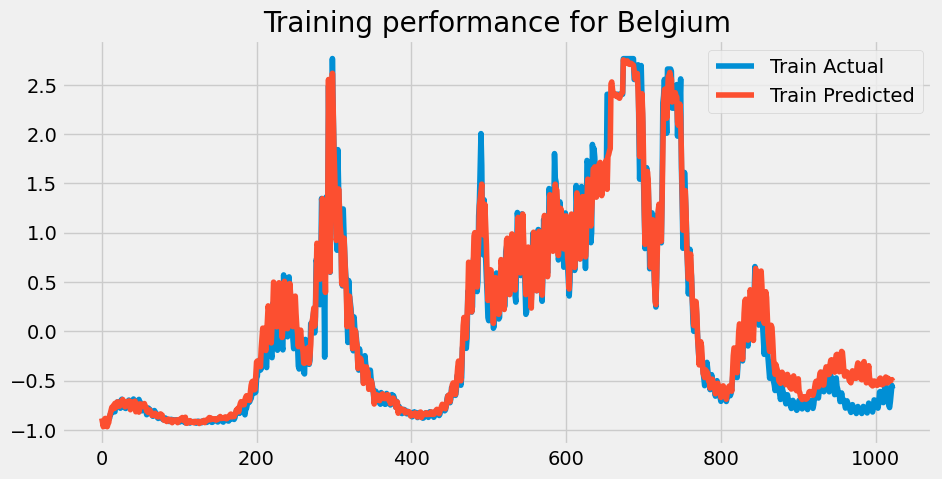

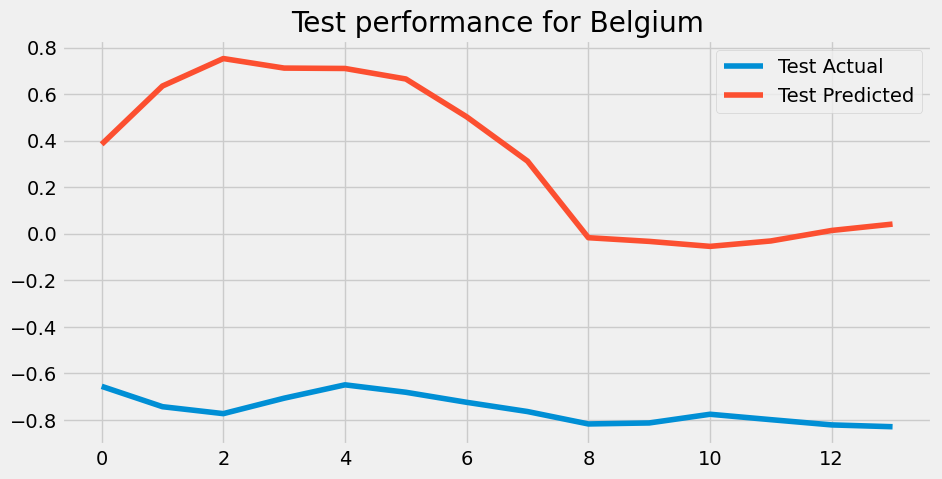

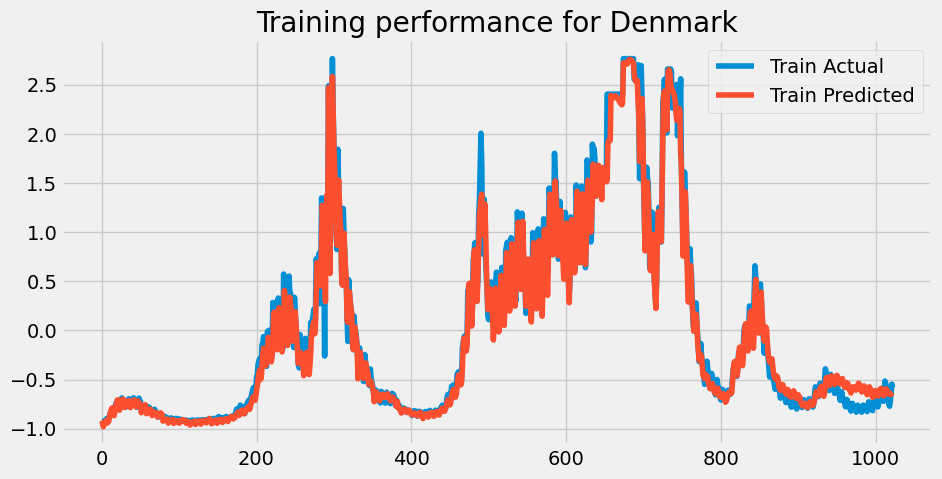

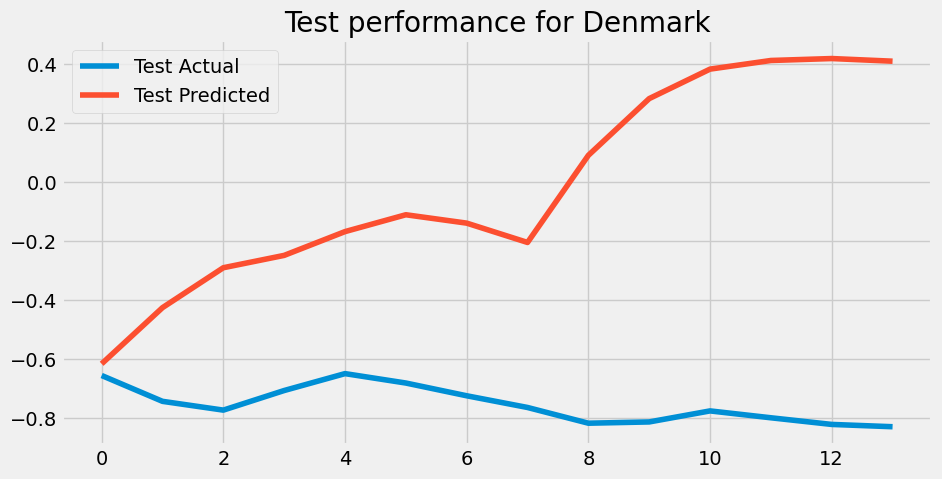

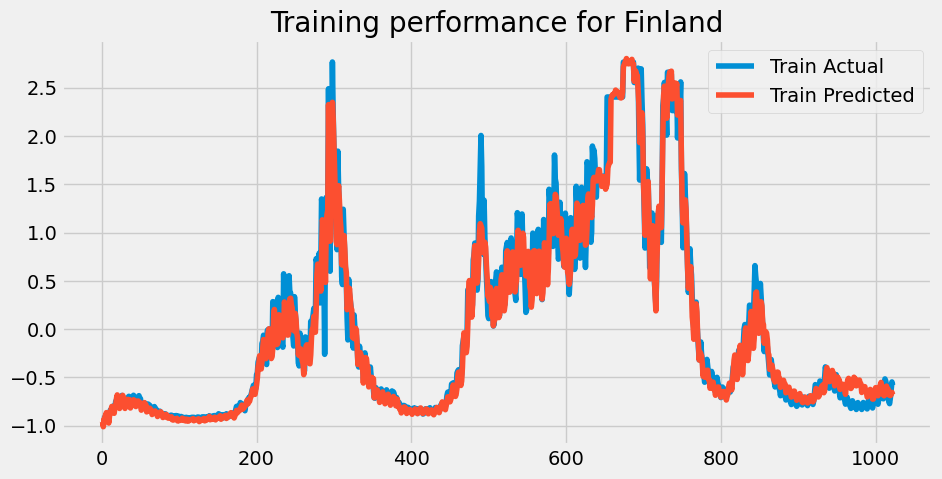

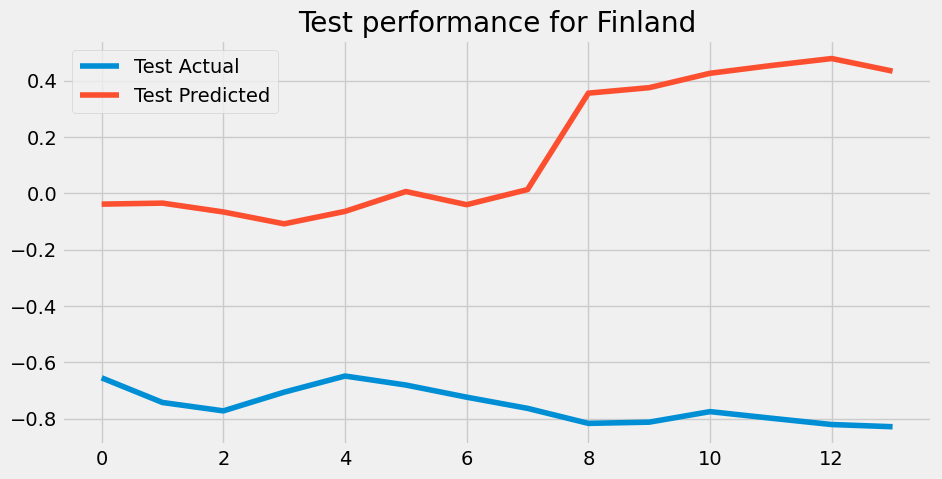

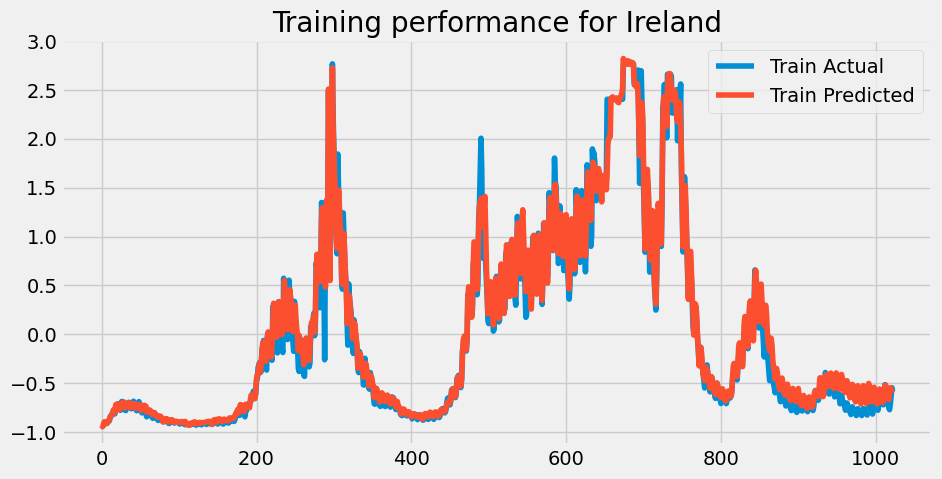

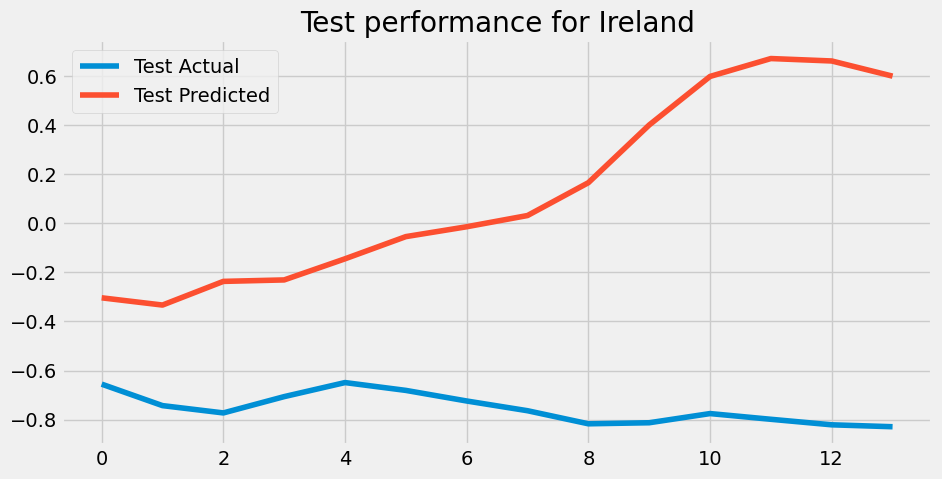

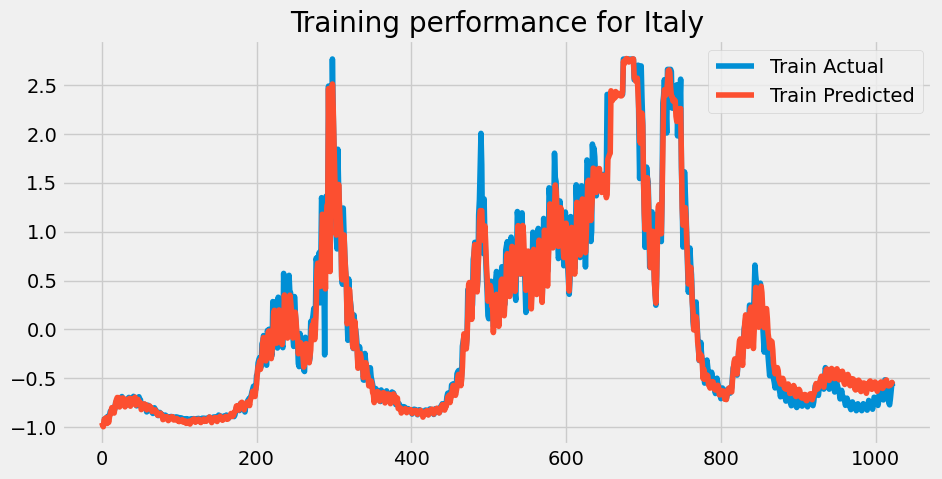

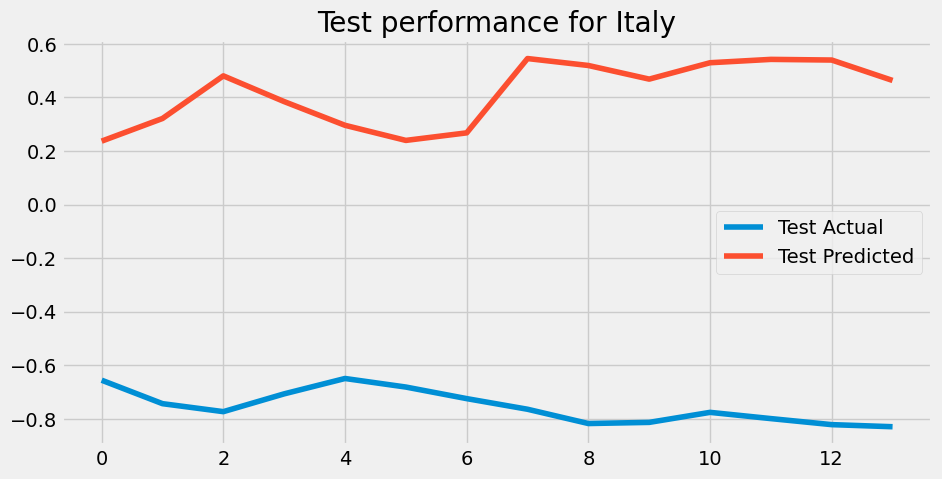

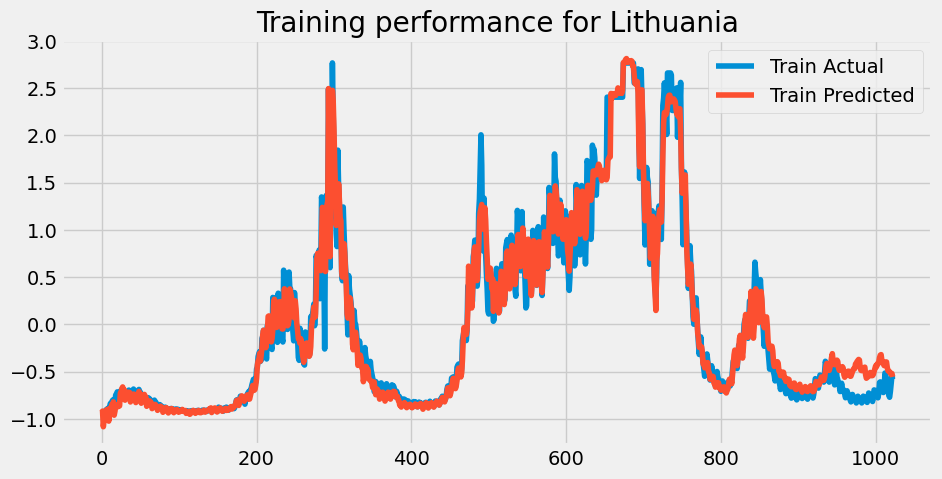

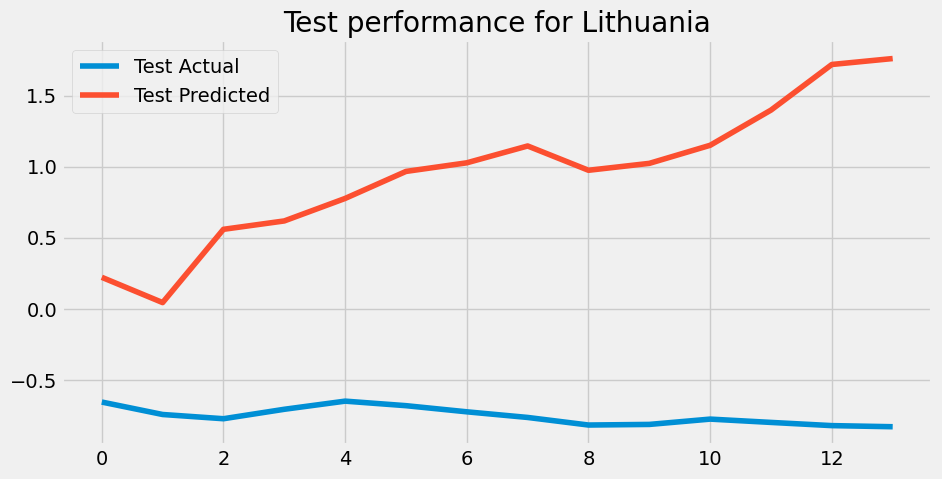

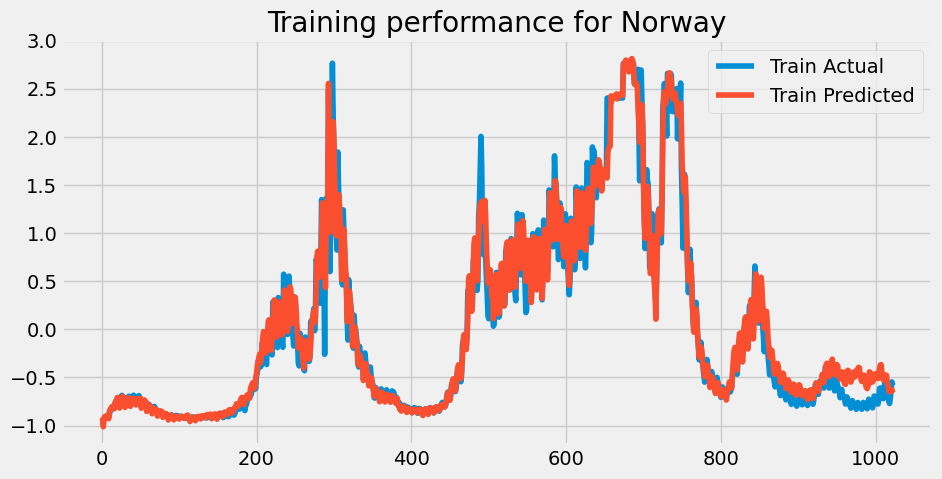

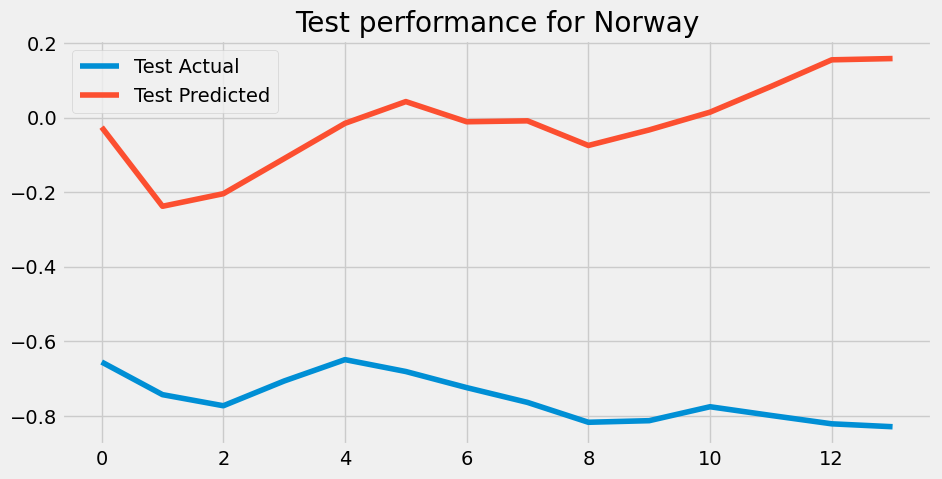

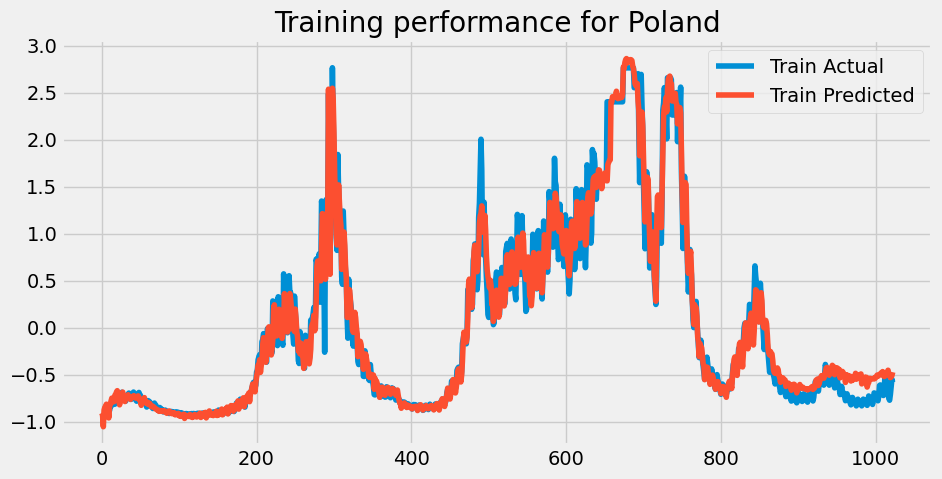

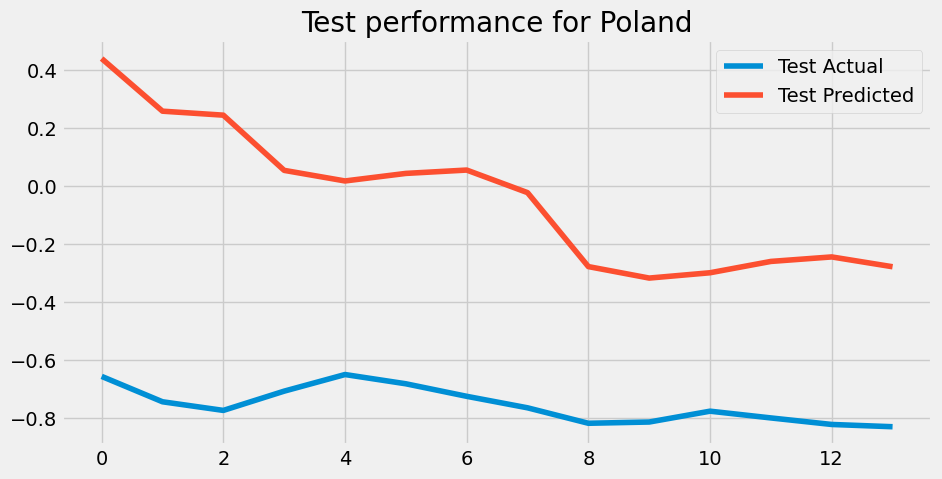

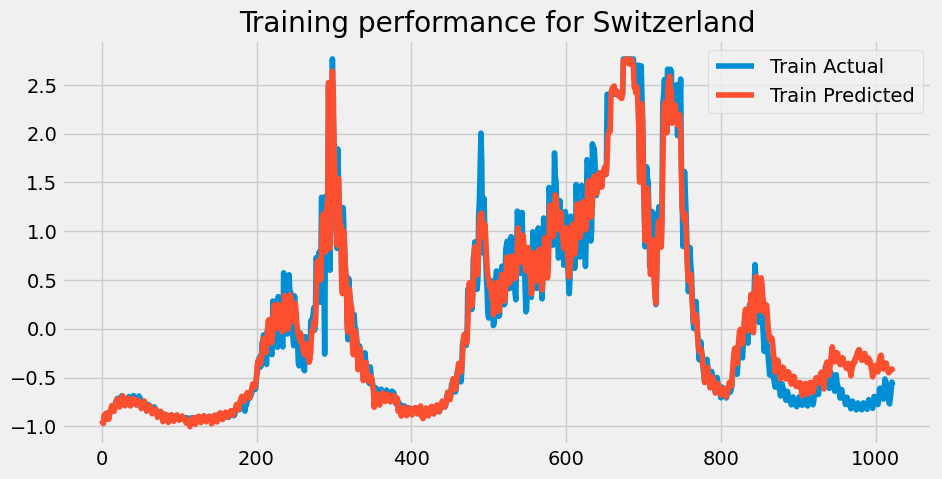

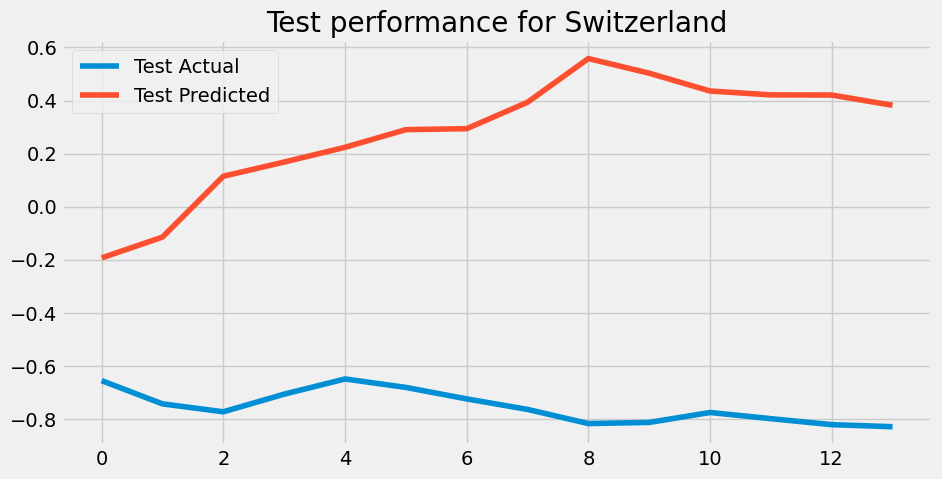

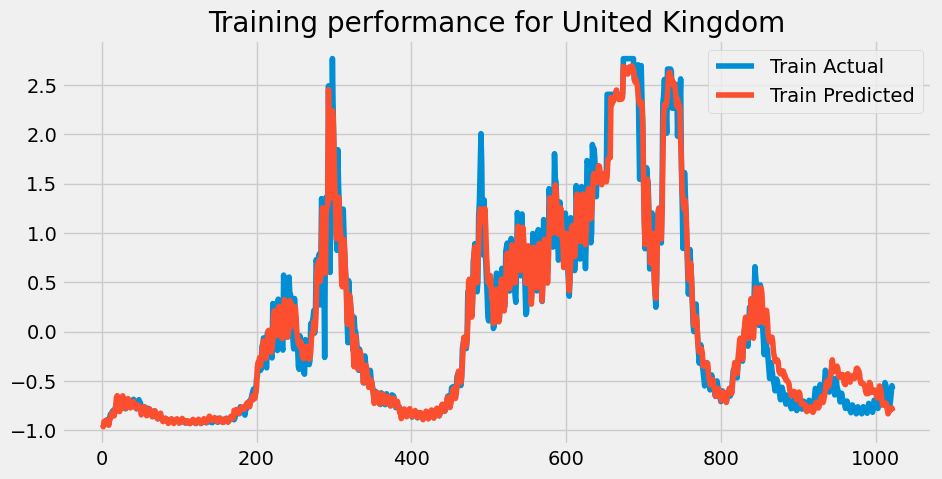

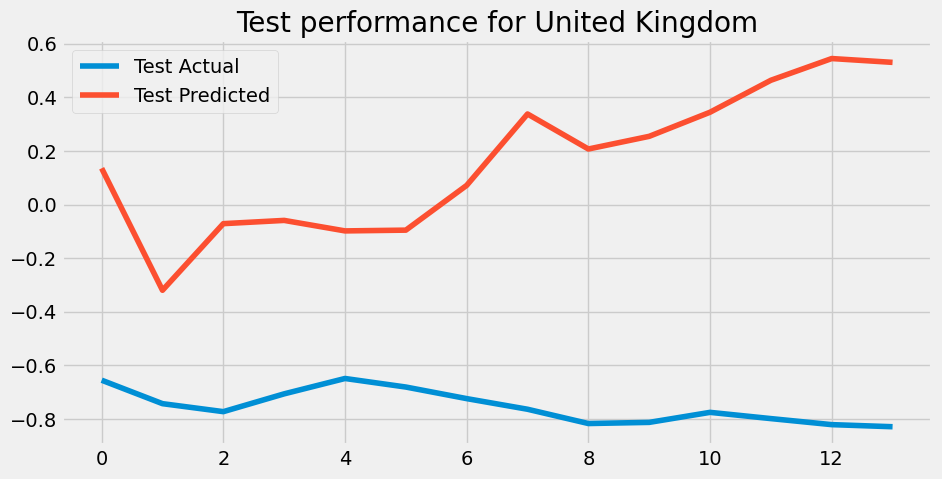

                Train_RMSE  Test_RMSE
Belgium           0.164944   1.116888
Denmark           0.133691   0.830889
Finland           0.153204   0.952589
Ireland           0.126775   0.975689
Italy             0.148921   1.182543
Lithuania         0.162094   1.786230
Norway            0.153203   0.747955
Poland            0.152420   0.739312
Switzerland       0.181944   1.063424
United Kingdom    0.166296   0.962199


In [100]:
# plots

for country in country_list:
    y_train, train_pred = train_plot_data[country]
    plt.figure(figsize=(10, 5))
    plt.plot(y_train, label='Train Actual')
    plt.plot(train_pred, label='Train Predicted')
    plt.title(f'Training performance for {country}')
    plt.legend()
    plt.show()

    y_test, test_pred = test_plot_data[country]
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Test Actual')
    plt.plot(test_pred, label='Test Predicted')
    plt.title(f'Test performance for {country}')
    plt.legend()
    plt.show()


# RMSE
rmse_df = pd.DataFrame({'Train_RMSE': train_rmse, 'Test_RMSE': test_rmse})
print(rmse_df)

32/32 [==============================] - 0s 2ms/step


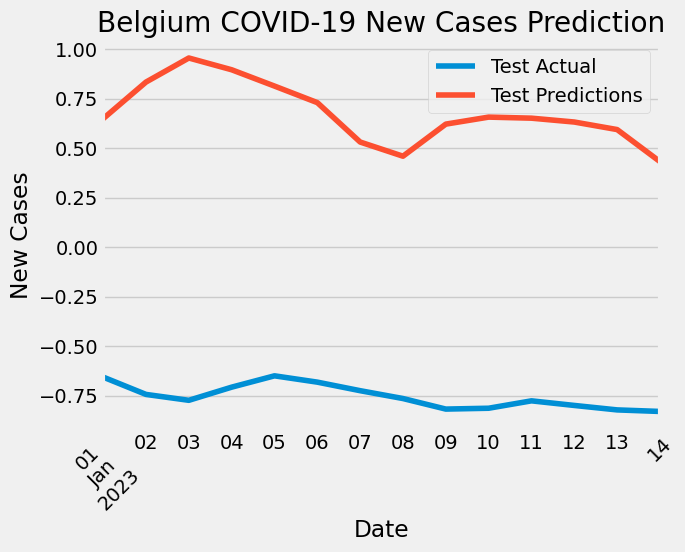

32/32 [==============================] - 0s 4ms/step


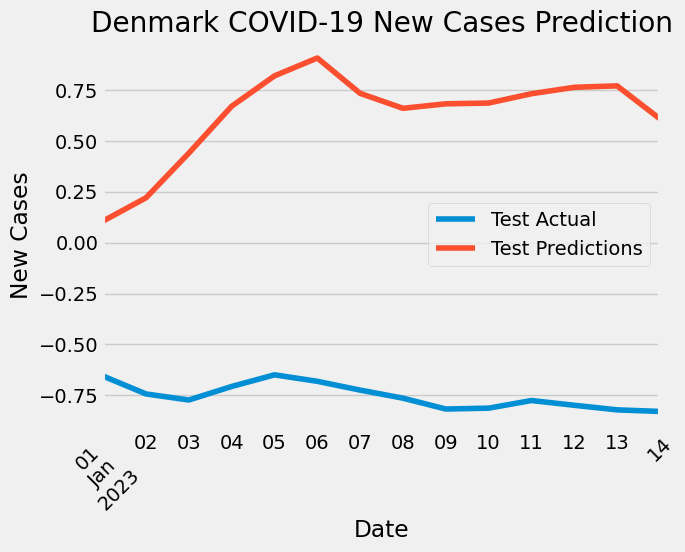

32/32 [==============================] - 0s 4ms/step


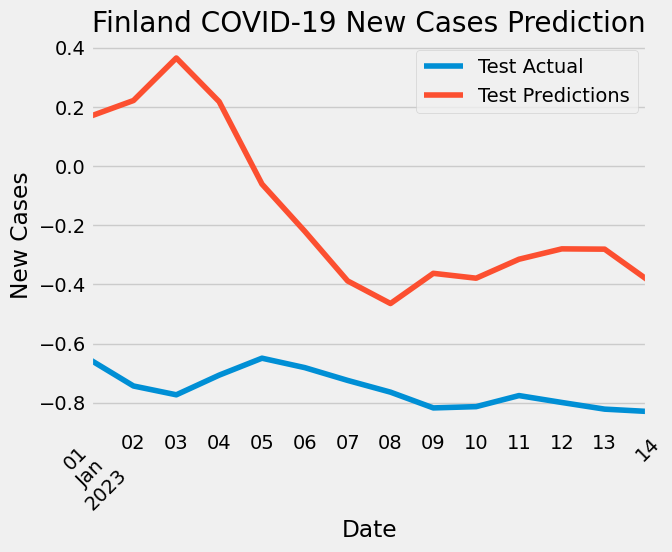

32/32 [==============================] - 0s 2ms/step


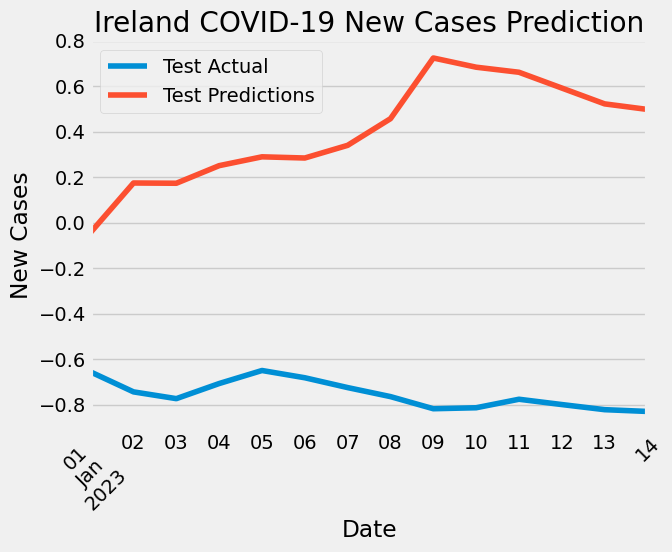

32/32 [==============================] - 0s 3ms/step


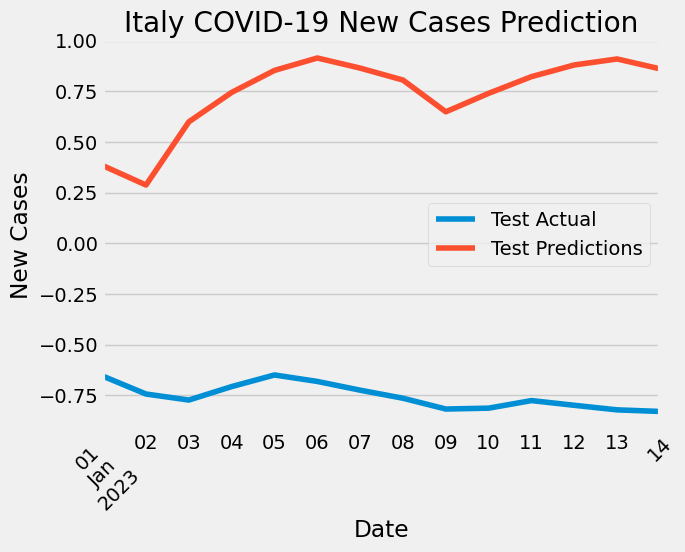

32/32 [==============================] - 0s 2ms/step


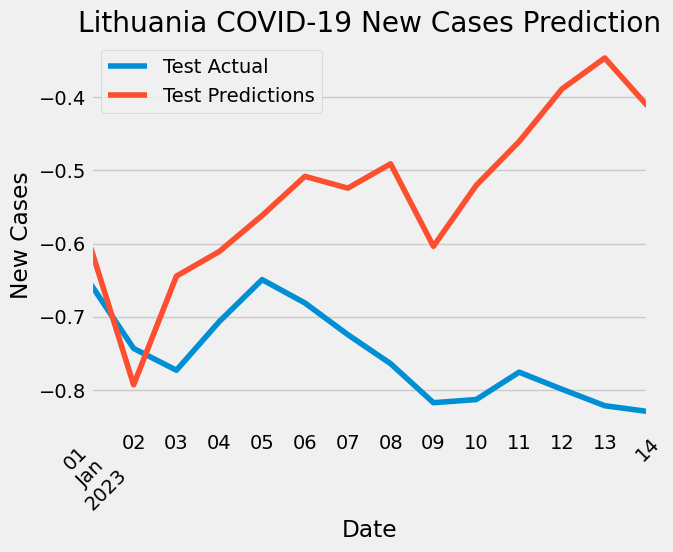

32/32 [==============================] - 0s 3ms/step


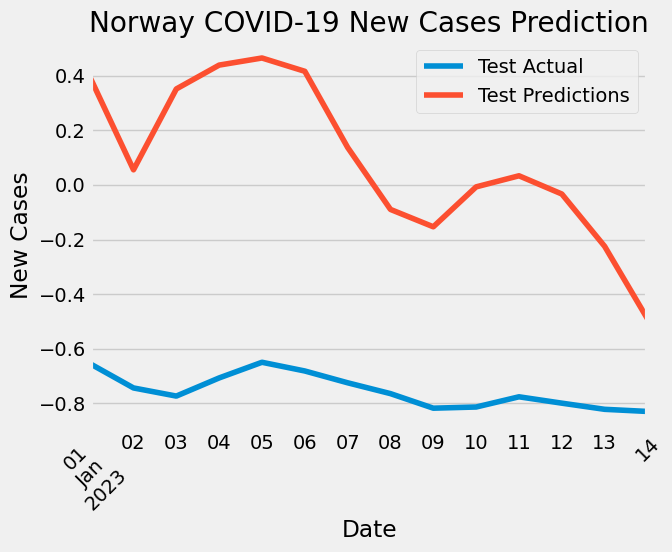

32/32 [==============================] - 0s 3ms/step


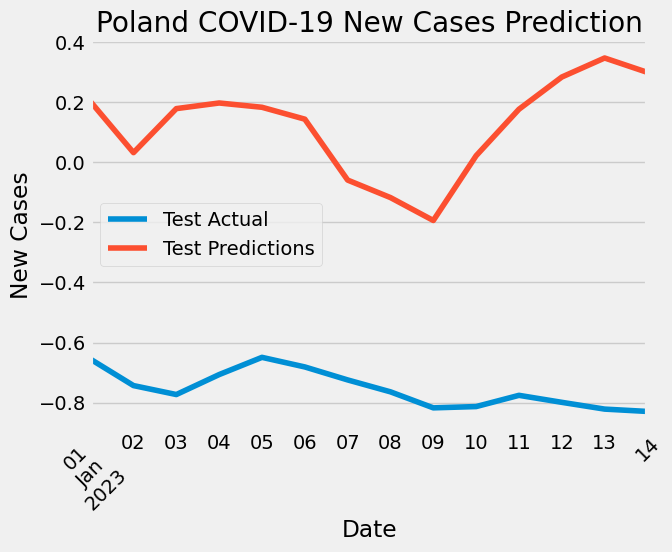

32/32 [==============================] - 0s 4ms/step


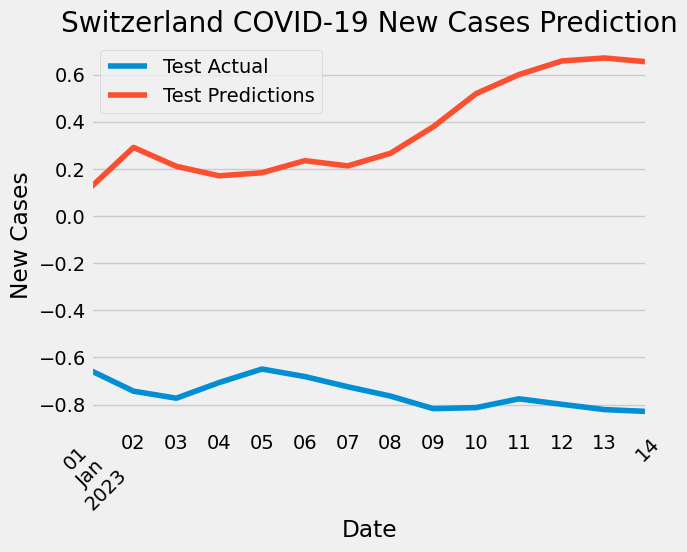

32/32 [==============================] - 0s 2ms/step


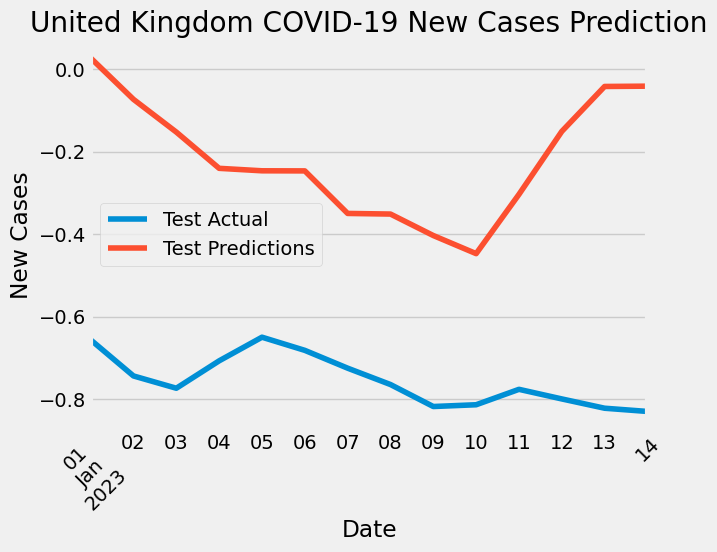

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def index_to_datetime(index):
    start_date = datetime.strptime('2020-03-01', '%Y-%m-%d')
    return start_date + timedelta(days=index)



for country in country_list:

    # Reformat dates for plotting
    test_dates = [index_to_datetime(x[0]) for x in country_test[country]]
    test_pred_df = pd.DataFrame(test_pred, columns=['yhat'], index=test_dates)
    test_gt_df = pd.DataFrame(test_pred, columns=['y'], index=test_dates)

    # Plotting
    pd.concat([test_gt_df, test_pred_df], axis=1).plot()
    plt.legend(['Test Actual', 'Test Predictions'])
    plt.title(country + ' COVID-19 New Cases Prediction')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.xticks(rotation=45)
    plt.show()



In [104]:
grid_search_arima = [321.73, 261.11, 143.55, 397.39, 9753.83, 244.72, 53.88, 775.08, 193.99, 4247.60]
auto_arima = [220.94, 250.81, 69.60, 309.27, 9945.40, 182.41, 38.13, 225.60, 230.26, 3270.86]
prophet_uni = [284.48, 456.14, 365.18, 323.66, 18488.45, 257.37, 96.94, 303.85, 1474.74, 3902.53]
prophet_multi = [359.76, 585.20, 314.10, 358.55, 32726.57, 281.57, 117.86, 357.32, 711.04, 2932.61]
xgb = [222.64, 228.84, 79.41, 549.05, 5580.92, 166.36,
 100.60,
 291.64,
 319.01,
 963.80]

lstm = [1.12, 0.83, 0.95, 0.98, 1.18, 1.79, 0.75, 0.74, 1.06, 0.96]

rmse_across_models = pd.DataFrame({
    'Location': countries,
    'Grid Search ARIMA': grid_search_arima,
    'Auto-ARIMA': auto_arima,
    'Prophet Univariate': prophet_uni,
    'Prophet Multivariate': prophet_multi,
    'XGBoost': xgb,
    'LSTM': lstm
})

rmse_across_models


,Location,Grid Search ARIMA,Auto-ARIMA,Prophet Univariate,Prophet Multivariate,XGBoost,LSTM
0,Belgium,321.73,220.94,284.48,359.76,222.64,1.12
1,Denmark,261.11,250.81,456.14,585.20,228.84,0.83
2,Finland,143.55,69.60,365.18,314.10,79.41,0.95
3,Ireland,397.39,309.27,323.66,358.55,549.05,0.98
4,Italy,9753.83,9945.40,18488.45,32726.57,5580.92,1.18
5,Lithuania,244.72,182.41,257.37,281.57,166.36,1.79
6,Norway,53.88,38.13,96.94,117.86,100.60,0.75
7,Poland,775.08,225.60,303.85,357.32,291.64,0.74
8,Switzerland,193.99,230.26,1474.74,711.04,319.01,1.06
9,United Kingdom,4247.60,3270.86,3902.53,2932.61,963.80,0.96
